In [29]:
import scipy.io
import scipy.io as sio
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from scipy.signal import resample
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from statsmodels.formula.api import ols

In [426]:
file_name[-17:-4]

'N4_2024_03_26'

### Data loading function 

In [30]:
# Function to load and process the reorganized MAT files
def load_reorganized_mat_file(file_path, file_name):
    mat_data = scipy.io.loadmat(file_path)
    neurons = mat_data['neurons'][0]  # Access the structured array

    processed_data = []
    
    for neuron in neurons:
        free50fr0 = neuron['free50FR0']
        tone50fr0 = neuron['tone50FR0']
        free100fr0 = neuron['free100FR0']
        tone100fr0 = neuron['tone100FR0']
        outcome = neuron['Outcome'].flatten()
        rt = neuron['RT'].flatten()
        tonet = neuron['ToneT'].flatten()
        info = file_name[-17:-4]
        
        # Organize data into a dictionary or DataFrame
        neuron_data = {
            'free50FR0': [fr0_entry[0] for fr0_entry in free50fr0],
            'tone50FR0': [fr0_entry[0] for fr0_entry in tone50fr0],
            'free100FR0': [fr0_entry[0] for fr0_entry in free100fr0],
            'tone100FR0': [fr0_entry[0] for fr0_entry in tone100fr0],
            'Outcome': outcome,
            'RT': rt,
            'ToneT': tonet,
            'info': info
        }
        
        processed_data.append(neuron_data)
    
    return processed_data

# Example usage
directory_path = r'M:\My Drive\Response Inhibition Project\2021-22_Attention\NP 2024-7\session firing rate trace struct full mixed window'
root_path = r'M:\My Drive\Response Inhibition Project\2021-22_Attention\NP 2024-7\anticipation firing rate fitting result'
all_sessions_data = []

for file_name in os.listdir(directory_path):
    file_path = os.path.join(directory_path, file_name)
    session_data = load_reorganized_mat_file(file_path, file_name)
    all_sessions_data.append(session_data)

print("Num of sessions:", len(all_sessions_data))
print("Num of neurons in the 1st session:", len(all_sessions_data[0]))
print('Num of trials in the 1st session:', len(all_sessions_data[0][0]['RT']))
print('Duration of withholding in the 1st trial: ' + str(all_sessions_data[0][0]['tone100FR0'][0].shape[1]/10) + ' s')
print('Max and min tone duration in the 1st session: ' + str(np.max(all_sessions_data[0][0]['ToneT'])) + ' and ' + str(np.min(all_sessions_data[0][0]['ToneT'])) + ' s')


Num of sessions: 91
Num of neurons in the 1st session: 48
Num of trials in the 1st session: 113
Duration of withholding in the 1st trial: 5.1 s
Max and min tone duration in the 1st session: 11.856552171331481 and 5.023251770614648 s


In [431]:
print(all_sessions_data[0][1].keys())

dict_keys(['free50FR0', 'tone50FR0', 'free100FR0', 'tone100FR0', 'Outcome', 'RT', 'ToneT', 'info'])


### Modeling functions 

In [320]:
a = np.linspace(0, 12, 1000)
a.shape
downsample_vector(a, 1000, 10).shape

(10,)

In [412]:
example_session_data = all_sessions_data[0][0]['FR0'][45]
example_session_data.shape[1]

92

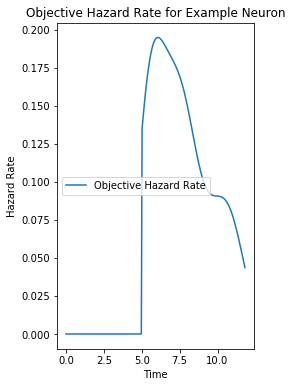

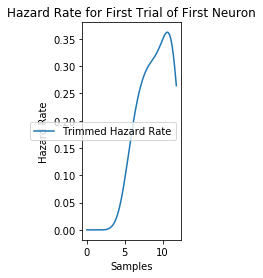

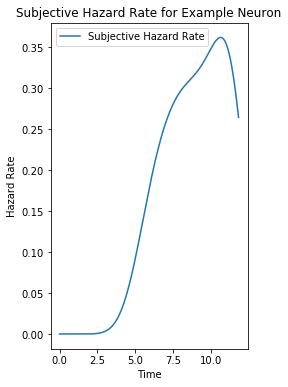

In [56]:
# Function to compute the subjective hazard rate based on inhibition tone duration

def gaussian_blur(y, sz, sigma):
    """
    Applies a Gaussian blur to the input array N using convolution.
    
    Parameters:
    - y: Array-like, the input array (PDF)
    - sz: Integer, the size of the Gaussian filter
    - sigma: Float, the standard deviation of the Gaussian filter
    
    Returns:
    - yfilt: Array-like, the blurred output array
    """
    x = np.linspace(-sz/2, sz/2, sz)
    gaussFilter = np.exp(-x**2 / (2 * sigma**2))
    gaussFilter = gaussFilter / np.sum(gaussFilter)
    yfilt = convolve(y, gaussFilter, mode='same')  # 'same' mode to keep the output size same as input

    return yfilt

def compute_subjective_hazard_rate(inhibition_durations, phi):
    """
    Computes the subjective hazard rate based on inhibition tone durations and a blurring factor phi.

    Parameters:
    - inhibition_durations: Array-like, durations of inhibition tones
    - phi: Float, blurring factor for the Gaussian blur

    Returns:
    - t_bins: Array of time bins
    - PDF: Probability density function values
    - CDF: Cumulative distribution function values
    - subjective_hazard_rate: Computed subjective hazard rate
    """
    # Kernel density estimation for PDF
    kde = stats.gaussian_kde(inhibition_durations)
    max_duration = max(inhibition_durations)
    t_bins = np.linspace(0, max_duration, round(max_duration * 10))
    PDF = kde(t_bins)
    
    # Set PDF to 0 for t=0 to the t_bin next to min(inhibition_durations)
    min_duration_index = np.searchsorted(t_bins, min(inhibition_durations), side='right')
    PDF[:min_duration_index] = 0
    
#     # Create a toy example of PDF
#     toy_t_bins = np.linspace(0, 12, 120)
#     toy_PDF = np.zeros_like(toy_t_bins)
#     exp_part = np.exp(-0.45 * (toy_t_bins[toy_t_bins >= 5] - 5))
#     toy_PDF[toy_t_bins >= 5] = exp_part / np.sum(exp_part)  # normalize to sum to 1
    
    # Compute CDF using cumulative trapezoidal integration
    CDF = cumtrapz(PDF, t_bins, initial=0)
    
    # Survival function (1 - CDF)
    survival_function = PDF / (1 - CDF)
    
    # Apply Gaussian blur to the PDF using convolution
    blurred_PDF = gaussian_blur(PDF, 60, 10)
    
#     # Apply Gaussian blur to the PDF
#     blurred_PDF = np.zeros_like(PDF)
#     for i in range(len(t_bins)):
#         # Gaussian kernel centered at t_bins[i]
#         blur = np.exp(-(t_bins[i] - t_bins)**2 / (2 * (phi * t_bins[i])**2)) / (np.sqrt(2 * np.pi) * phi * t_bins[i])
#         blurred_PDF[i] = np.sum(PDF * blur)
        
    blurred_PDF = np.nan_to_num(blurred_PDF, nan=0.0)
#     print(blurred_PDF)
#     # Normalize blurred_PDF to ensure the area under the curve equals 1
#     blurred_PDF /= np.trapz(blurred_PDF, t_bins)
    
    # Compute blurred CDF using cumulative trapezoidal integration
    blurred_CDF = cumtrapz(blurred_PDF, t_bins, initial=0)
#     print(blurred_CDF)
    
    # Compute subjective hazard rate
    subjective_hazard_rate = blurred_PDF / (1 - blurred_CDF)
    
    return t_bins, PDF, CDF, survival_function, subjective_hazard_rate

# # Function to interpolate hazard rate, preserving zeros
# def interpolate_hazard_rate(t_bins, subjective_hazard_rate, num_samples):
#     interpolated_hazard_rate = interp1d(t_bins, subjective_hazard_rate, kind='linear', fill_value="extrapolate")(np.linspace(min(t_bins), max(t_bins), num_samples))
    
#     # Preserve zeros in the original subjective hazard rate
#     zero_indices = np.where(subjective_hazard_rate == 0)[0]
#     if len(zero_indices) > 0:
#         zero_time_points = t_bins[zero_indices]
#         zero_interpolated_indices = np.searchsorted(np.linspace(min(t_bins), max(t_bins), num_samples), zero_time_points)
#         interpolated_hazard_rate[zero_interpolated_indices] = 0

#     return interpolated_hazard_rate

def trim_hazard_rate(t_bins, survival_function, num_samples):
    t_bins_trimmed = t_bins[:num_samples]
    survival_function_trimmed = survival_function[:num_samples]
    
    return t_bins_trimmed, survival_function_trimmed


example_session_toneT = all_sessions_data[12][0]['ToneT']
t_bins, PDF, CDF, survival_function, subjective_hazard_rate = compute_subjective_hazard_rate(example_session_toneT, 0.26)
# Plot the objective hazard rate
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(t_bins, PDF, label='Objective Hazard Rate')
plt.xlabel('Time')
plt.ylabel('Hazard Rate')
plt.title('Objective Hazard Rate for Example Neuron')
plt.legend()
plt.show()
    
example_session_data = all_sessions_data[5][0]['free100FR0'][2]
# interpolated_hazard_rate = interp1d(t_bins, CDF, kind='linear', fill_value="extrapolate")(np.linspace(min(t_bins), max(t_bins), example_neuron_data.shape[1]))
t_bins_trimmed, subjective_hazard_rate_trimmed = trim_hazard_rate(t_bins, subjective_hazard_rate, example_session_data.shape[1])
# Plot the interpolated objective hazard rate
plt.subplot(1, 3, 2)
plt.plot(t_bins_trimmed, subjective_hazard_rate_trimmed, label='Trimmed Hazard Rate')
plt.xlabel('Samples')
plt.ylabel('Hazard Rate')
plt.title('Hazard Rate for First Trial of First Neuron')
plt.legend()

# Plot the subjective hazard rate
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 3)
plt.plot(t_bins, subjective_hazard_rate, label='Subjective Hazard Rate')
plt.xlabel('Time')
plt.ylabel('Hazard Rate')
plt.title('Subjective Hazard Rate for Example Neuron')
plt.legend()

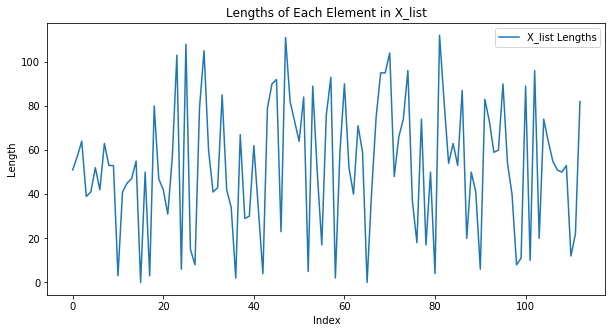

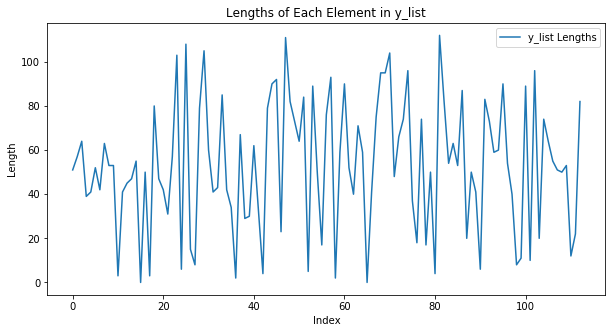

In [207]:
example_neuron_data = all_sessions_data[0][0]['FR0']
fr0 = example_neuron_data
X_list = []
y_list = []
for trial_index in range(len(fr0)):
    fr0_trial = fr0[trial_index]
    interpolated_hazard_rate = interp1d(t_bins, CDF, kind='linear', fill_value="extrapolate")(np.linspace(min(t_bins), max(t_bins), fr0_trial.shape[1]))
    X_list.append(interpolated_hazard_rate)
    fr0_trial_flattened = fr0_trial.flatten()
    y_list.append(fr0_trial_flattened)
    
# Plot the lengths of each element in X_list
x_lengths = [x.shape[0] for x in X_list]
plt.figure(figsize=(10, 5))
plt.plot(x_lengths, label='X_list Lengths')
plt.xlabel('Index')
plt.ylabel('Length')
plt.title('Lengths of Each Element in X_list')
plt.legend()
plt.show()

# Plot the lengths of each element in y_list
y_lengths = [y.shape[0] for y in y_list]
plt.figure(figsize=(10, 5))
plt.plot(y_lengths, label='y_list Lengths')
plt.xlabel('Index')
plt.ylabel('Length')
plt.title('Lengths of Each Element in y_list')
plt.legend()
plt.show()

In [106]:
indices = np.sort(np.random.choice(np.arange(1, 47), size=3, replace=False))
np.any(indices==2)

False

#### Force the length of time series

In [57]:

def forced_length_converter(fr0_trial, survival_function, target_length=50):
    """
    Adjusts the length of fr0_trial and survival_function to have exactly 50 data points.

    Parameters:
    - fr0_trial: Array-like, the input firing rate data for a trial (shape: [n_samples, n_features])
    - survival_function: Array-like, the input survival function corresponding to fr0_trial (shape: [n_samples])
    - target_length: Integer, the desired length of the output arrays (default is 50)

    Returns:
    - forced_fr0_trial: Array-like, the adjusted fr0_trial with length equal to target_length
    - forced_survival_function: Array-like, the adjusted survival function with length equal to target_length
    """
    
    num_points = fr0_trial.shape[1]  # Number of points in fr0_trial
    survival_function_trimmed = survival_function[:num_points]
    if num_points < target_length:
        # Case 1: fr0_trial has fewer points than target_length
        # Randomly select points to interpolate
        extra_points_needed = target_length - num_points
#         print(extra_points_needed)
#         print(num_points)
        # for backward interpolation, ensure that any interpolation index is non-negative
        valid_interpolations = True
        while valid_interpolations:
            interpolated_indices = np.sort(np.random.choice(np.arange(1, num_points), size=extra_points_needed, replace=False))
            valid_interpolations = np.any(interpolated_indices == 0)
            
#         print(interpolated_indices)
#         print(fr0_trial)
        # Initialize forced_fr0_trial and forced_survival_function with the original values
        forced_fr0_trial = fr0_trial.copy()
        forced_survival_function = survival_function[:num_points].copy()
        for index in interpolated_indices:
            # Calculate the average between fr0_trial[:, index] and fr0_trial[:, index - 1]
            avg_value = (forced_fr0_trial[:, index - 1] + forced_fr0_trial[:, index]) / 2
            
            # Insert the average value between the two data points
            forced_fr0_trial = np.insert(forced_fr0_trial, index, avg_value, axis=1)
            
            # Similarly, calculate the average for the survival function and insert
            avg_survival_value = (forced_survival_function[index - 1] + forced_survival_function[index]) / 2
            forced_survival_function = np.insert(forced_survival_function, index, avg_survival_value)
        
        
#         # Interpolate fr0_trial
#         forced_fr0_trial = np.insert(fr0_trial, interpolated_indices, fr0_trial[:, interpolated_indices], axis=0)      
        
#         # Trim and interpolate survival_function
#         survival_function_trimmed = survival_function[:num_points]
#         forced_survival_function = np.insert(survival_function_trimmed, interpolated_indices, survival_function_trimmed[interpolated_indices])

    elif num_points > target_length:
        # Case 2: fr0_trial has more points than target_length
        # Randomly select 50 points chronologically
        selected_indices = np.sort(np.random.choice(np.arange(num_points), size=target_length, replace=False))
#         print(selected_indices.shape)
#         print(fr0_trial.shape)
        
        # Select points from fr0_trial
        forced_fr0_trial = fr0_trial[:, selected_indices]
        
        # Trim and select points from survival_function
        survival_function_trimmed = survival_function[:num_points]
        forced_survival_function = survival_function_trimmed[selected_indices]

    else:
        # Case 3: fr0_trial has exactly 50 points
        forced_fr0_trial = fr0_trial
        forced_survival_function = survival_function[:num_points]

    return forced_fr0_trial, forced_survival_function, survival_function_trimmed


#### One session one neuron example for fitting 

In [197]:
# Gradient descent fitting function
# def fit_firing_rates_with_hazard_rates(all_sessions_data, phi, tau_range, alpha=0.01, num_iterations=1000):
def fit_firing_rates_with_hazard_rates(all_sessions_data, phi, tau_range):
    optimal_weights = []
    optimal_intercepts = []
    p_values_weights = []
    p_values_intercepts = []

#     for session in all_sessions_data:
#         for neuron in session:
#             fr0 = neuron['FR0']
#             tonet = neuron['ToneT']

    neuron = all_sessions_data[0][0]
    fr0 = neuron['FR0']
    tonet = neuron['ToneT']
            
    t_bins, PDF, CDF, survival_function, subjective_hazard_rate = compute_subjective_hazard_rate(tonet, 0.26)
#             for tau in tau_range:

    weights = []
    intercepts = []

    for trial_index in range(len(fr0)):
        fr0_trial = fr0[trial_index]
#         interpolated_hazard_rate = interp1d(t_bins, CDF, kind='linear', fill_value="extrapolate")(np.linspace(min(t_bins), max(t_bins), fr0_trial.shape[1]))
        t_bins_trimmed, survival_function_trimmed = trim_hazard_rate(t_bins, survival_function, fr0_trial.shape[1])
        X_list.append(survival_function_trimmed.reshape(1, -1))
        y_list.append(fr0_trial.flatten())

#             X, y = concatenate_data(X_list, y_list)

#     # Initialize parameters
#     w = np.random.rand()
#     c = np.random.rand()
#     errors = []
    # Gradient Descent (customized)
#     for iteration  in range(num_iterations):
#         dw = 0
#         dc = 0
#         total_error = 0
#         for Xi, yi in zip(X_list, y_list):
# #             print(Xi)
#             yi_pred = c + w * Xi
#             error = yi - yi_pred
#             dw += -2 * np.sum(Xi * error) / len(Xi)
#             dc += -2 * np.sum(error) / len(Xi)
#         w -= alpha * dw
#         c -= alpha * dc
#         errors.append(total_error)
#         if iteration % 100 == 0:
#             print(f"Iteration: {iteration}, w: {w}, c: {c}, error: {total_error}")

    for trial_index in range(len(fr0)):
        print(trial_index)
        fr0_trial = fr0[trial_index]
        interpolated_hazard_rate = interp1d(t_bins, CDF, kind='linear', fill_value="extrapolate")(np.linspace(min(t_bins), max(t_bins), fr0_trial.shape[1]))
        
        # Reshape Xi for sklearn LinearRegression
        Xi = interpolated_hazard_rate.reshape(-1, 1)
        yi = fr0_trial.flatten()
        if interpolated_hazard_rate.shape[0] == 0 or fr0_trial.flatten().shape[0] == 0:
            continue

        # Fit the model using LinearRegression
        model = LinearRegression()
        model.fit(Xi, yi)

        w = model.coef_[0]
        c = model.intercept_

        weights.append(w)
        intercepts.append(c)

    # Perform t-test on weights
    weights = np.array(weights)
    t_statistic, p_value = stats.ttest_1samp(weights, 0)

    print(f"Weights: {weights}")
    print(f"t-statistic: {t_statistic}")
    print(f"p-value: {p_value}")
    
    # Plot mean ± SEM
    plt.figure(figsize=(10, 6))
    plt.errorbar([0], [np.mean(weights)], yerr=[stats.sem(weights)], fmt='o', capsize=5, label='Mean ± SEM')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlim(-1, 1)
    plt.xlabel('Weights')
    plt.ylabel('Value')
    plt.title('Mean ± SEM of Weights')
    plt.legend()
    plt.show()
    
#     return optimal_weights, optimal_intercepts, p_values_weights, p_values_intercepts
    return weights, t_statistic, p_value

#### Generalized function

In [418]:
# Fitting function for all sessions and neurons
def fit_firing_rates_with_hazard_rates(all_sessions_data, phi, session_indices=session_indices):
    lumped_neg_w = []
    lumped_pos_w = []
    sessions_pos_counts = []
    sessions_neg_counts = []
    session_idle_counts = []
    total_neurons_per_session = []

#     for session_index, session in enumerate(all_sessions_data):
    for session_index in session_indices:
        session = all_sessions_data[session_index]
        print(f"Processing Session {session_index}")
        pos_weights = []
        neg_weights = []
        pos_count = 0
        neg_count = 0
        idle_count = 0
        total_neurons = 0
        
        for neuron_index, neuron in enumerate(session):
            total_neurons += 1
            print(f"  Processing Neuron {neuron_index}")
            fr0 = neuron['tone100FR0']
            tonet = neuron['ToneT']
            
            t_bins, PDF, CDF, survival_function, subjective_hazard_rate = compute_subjective_hazard_rate(tonet, 0.26)
            weights = []

            for trial_index in range(len(fr0)):
                fr0_trial = fr0[trial_index]
#                 interpolated_hazard_rate = interp1d(t_bins, CDF, kind='linear', fill_value="extrapolate")(np.linspace(min(t_bins), max(t_bins), fr0_trial.shape[1]))
                t_bins_trimmed, subjective_hazard_rate_trimmed = trim_hazard_rate(t_bins, subjective_hazard_rate, fr0_trial.shape[1])
                
                
#                 Xi = interpolated_hazard_rate.reshape(-1, 1)
                Xi = subjective_hazard_rate_trimmed.reshape(-1, 1)
                yi = fr0_trial.flatten()
#                 if interpolated_hazard_rate.shape[0] == 0 or fr0_trial.flatten().shape[0] == 0:
                if subjective_hazard_rate_trimmed.shape[0] == 0 or fr0_trial.flatten().shape[0] == 0:
                    continue

                model = LinearRegression()
                model.fit(Xi, yi)

                w = model.coef_[0]
                weights.append(w)

            if len(weights) > 0:
                weights = np.array(weights)
                t_statistic, p_value = stats.ttest_1samp(weights, 0)
                
                if p_value < 0.05:
                    mean_weight = np.mean(weights)
                    if mean_weight > 0:
                        pos_weights.append(mean_weight)
                        pos_count += 1
                    else:
                        neg_weights.append(mean_weight)
                        neg_count += 1
                else:
                    idle_count += 1

        lumped_pos_w.append(np.mean(pos_weights) if pos_weights else np.nan)
        lumped_neg_w.append(np.mean(neg_weights) if neg_weights else np.nan)
        sessions_pos_counts.append(pos_count / total_neurons if total_neurons > 0 else 0)
        sessions_neg_counts.append(neg_count / total_neurons if total_neurons > 0 else 0)
        session_idle_counts.append(idle_count / total_neurons if total_neurons > 0 else 0)
        total_neurons_per_session.append(total_neurons)

    # Plot lumped positive weights
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(lumped_pos_w)), lumped_pos_w, 'o-', label='Mean Positive Weights')
#     plt.errorbar(range(len(lumped_pos_w)), lumped_pos_w, yerr=[stats.sem(lumped_pos_w)], fmt='o', capsize=5, label='Mean ± SEM')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Session Index')
    plt.ylabel('Mean Positive Weights')
    plt.title('Mean ± SEM of Positive Weights Over Sessions')
    plt.legend()
    plt.show()

    # Plot lumped negative weights
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(lumped_neg_w)), lumped_neg_w, 'o-', label='Mean Negative Weights')
#     plt.errorbar(range(len(lumped_neg_w)), lumped_neg_w, yerr=[stats.sem(lumped_neg_w)], fmt='o', capsize=5, label='Mean ± SEM')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Session Index')
    plt.ylabel('Mean Negative Weights')
    plt.title('Mean ± SEM of Negative Weights Over Sessions')
    plt.legend()
    plt.show()

    # Plot the number of significant positive neurons/total number of neurons over sessions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sessions_pos_counts)), sessions_pos_counts, 'o-', label='Proportion of Positive Significant Neurons')
    plt.xlabel('Session Index')
    plt.ylabel('Proportion')
    plt.title('Proportion of Positive Significant Neurons Over Sessions')
    plt.legend()
    plt.show()

    # Plot the number of significant negative neurons/total number of neurons over sessions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sessions_neg_counts)), sessions_neg_counts, 'o-', label='Proportion of Negative Significant Neurons')
    plt.xlabel('Session Index')
    plt.ylabel('Proportion')
    plt.title('Proportion of Negative Significant Neurons Over Sessions')
    plt.legend()
    plt.show()
    
    # Plot the number of non-tuning neurons/total number of neurons over sessions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(session_idle_counts)), session_idle_counts, 'o-', label='Proportion of Non Significant Neurons')
    plt.xlabel('Session Index')
    plt.ylabel('Proportion')
    plt.title('Proportion of Non Significant Neurons Over Sessions')
    plt.legend()
    plt.show()

In [319]:
interest_rate = [2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25,
                 2.25, 2.25, 2,2, 2, 1.75, 1.75, 1.75, 1.75,
                 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]

unemployment_rate = [5.3, 5.3, 5.3, 5.3, 5.4, 5.6, 5.5, 5.5,
                     5.5, 5.6, 5.7, 5.9, 6, 5.9, 5.8, 6.1,
                     6.2, 6.1, 6.1, 6.1, 5.9, 6.2, 6.2, 6.1]

stock_index_price = [1464, 1394, 1357, 1293, 1256, 1254, 1234,
                     1195, 1159, 1167, 1130, 1075, 1047, 965, 943,
                     958, 971, 949, 884, 866, 876, 822, 704, 719]

y = np.mat(stock_index_price)

print(y.shape)

X = np.mat(interest_rate**np.arange(1)[:, None])
print(X.shape)

betas = np.asarray(y * X.T * (X*X.T).I)[0]
print(betas)

[[1464 1394 1357 1293 1256 1254 1234 1195 1159 1167 1130 1075 1047  965
   943  958  971  949  884  866  876  822  704  719]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[1070.08333333]


In [325]:
(YY*YY.T).I

AttributeError: 'numpy.ndarray' object has no attribute 'I'

In [356]:
XX = np.mat(X_matrix[60, :].reshape(1, -1))
YY = np.mat(y_matrix[60, :].reshape(1, -1))
print(XX)
print(YY)
betas = np.asarray(YY * XX.T * (XX*XX.T).I)[0]
print(betas)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.00119369 0.0025739
  0.00414446 0.00590747 0.0078636  0.01001226 0.0123519  0.01488018
  0.01759413 0.02049029 0.02356475 0.02681326 0.03023118 0.03381361
  0.03755538 0.04145116 0.04968311 0.05400872 0.05846743 0.06776675
  0.0725999  0.07755135 0.0826187  0.08779993 0.09309329 0.09849706
  0.10400934 0.10962787]]
[[ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  0 10  0  0 10  0 10  0 10  0
   0  0  0 10  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
[2.95741837]


In [402]:

weights = []
for i in range(X_matrix.shape[1]):
    X_col = X_matrix[:, i].reshape(-1, 1)
    y_col = y_matrix[:, i].reshape(-1, 1)
    model = LinearRegression()
    model.fit(X_col, y_col)
    weights.append(model.coef_[0])

weights = np.array(weights)
mean_weight = np.mean(weights)
std_weight = np.std(weights)
lower_bound = mean_weight - 3 * std_weight
upper_bound = mean_weight + 3 * std_weight
mask = (weights >= -300) & (weights <= 300)
filtered_weights = weights[mask]
np.mean(filtered_weights)

-4.060010696396581

#### Linear regression weight optimization Y^ ~ w*X^+ c (w, c are scalar)

In [58]:


def linear_regression_vector_with_pvalues(X, y):
    """
    This function computes the scalar values w and c for a linear regression problem
    where each sample in X and y is a vector, and also calculates the standard errors
    and p-values of the estimates.
    
    Parameters:
    X (numpy.ndarray): A matrix where each row is a sample vector (shape: [N, D]).
    y (numpy.ndarray): A matrix where each row is the corresponding target vector (shape: [N, D]).
    
    Returns:
    tuple: A tuple (w, c, SE_w, SE_c, p_w, p_c) where w is the scalar weight, c is the scalar intercept,
           SE_w is the standard error of w, SE_c is the standard error of c,
           p_w is the p-value for w, and p_c is the p-value for c.
    """
    if X.shape != y.shape:
        raise ValueError("X and y must have the same shape")
    N, D = X.shape
    
    # Compute Jacobian matrix and determinant
    sum_X = np.sum(X)
    sum_y = np.sum(y)
    sum_X_y = np.sum(X * y)
    sum_X2 = np.sum(X**2)
    w = (sum_X_y - (sum_X * sum_y) / (N * D)) / (sum_X2 - (sum_X**2 / (N * D)))
    c = (sum_y - w * sum_X) / (N * D)
    
    # Calculate residuals and RSS
    y_pred = w * X + c
    residuals = y - y_pred
    RSS = np.sum(residuals**2)
    sigma2_hat = RSS / (N * D - 2)
    X_mean = sum_X / (N * D)
    Var_w = sigma2_hat / (sum_X2 - (sum_X**2 / (N * D)))
    Var_c = sigma2_hat * (1 / (N * D) + (X_mean**2) / (sum_X2 - (sum_X**2 / (N * D))))
    SE_w = np.sqrt(Var_w)
    SE_c = np.sqrt(Var_c)
    t_w = w / SE_w
    t_c = c / SE_c
    df = N * D - 2
    p_w = 2 * (1 - t.cdf(np.abs(t_w), df))
    p_c = 2 * (1 - t.cdf(np.abs(t_c), df))
    
    return w, c, SE_w, SE_c, p_w, p_c


# w, c, SE_w, SE_c, p_w, p_c = linear_regression_vector_with_pvalues(X_matrix, y_matrix)
# print(w)
# print(p_w)

In [500]:
y[6].shape

(1, 50)

#### Example forced-length outputs

In [508]:
neuron = all_sessions_data[5][4]
fr0 = neuron['tone100FR0']
tonet = neuron['ToneT']
outcome = neuron['Outcome']
t_bins, PDF, CDF, survival_function, subjective_hazard_rate = compute_subjective_hazard_rate(tonet, 0.26)
X = []
X_orig = []
y = []
weights = []

for trial_index in range(len(fr0)):
    fr0_trial = fr0[trial_index]
    if outcome[trial_index] == 0:
        if fr0_trial.shape[1] > 5:  # Ensure there are more than 5 samples to cut
            fr0_trial = fr0_trial[:, :-5]
    if fr0_trial.shape[1] < 30:
        continue
    yi, Xi, Xi_orig = forced_length_converter(fr0_trial, subjective_hazard_rate, target_length=50)
    X.append(Xi)
    y.append(yi.flatten())
    X_orig.append(Xi_orig)
#     if len(X) >= 10:
#         break

X_matrix = np.vstack(X)
y_matrix = np.vstack(y)


print("Total num of subjective_hazard_rate traces: ", X_matrix.shape[0])
print("Total num of fr0_trial: ", y_matrix.shape[0])


# fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 20))

# for i in range(10):
#     axes[i, 0].plot(X_orig[i], color='blue')
#     axes[i, 0].plot(X[i], color='red')
#     axes[i, 1].plot(y[i].flatten(), color='blue')
# plt.tight_layout()
# plt.show()

(1, 5)
(1, 92)
(1, 67)
(1, 57)
(1, 19)
(1, 45)
(1, 12)
(1, 47)
(1, 16)
(1, 6)
(1, 70)
(1, 28)
(1, 30)
(1, 65)
(1, 45)
(1, 39)
(1, 48)
(1, 39)
(1, 55)
(1, 94)
(1, 45)
(1, 44)
(1, 17)
(1, 54)
(1, 68)
(1, 19)
(1, 38)
(1, 35)
(1, 18)
(1, 24)
(1, 5)
(1, 11)
(1, 52)
(1, 11)
(1, 5)
(1, 71)
(1, 25)
(1, 109)
(1, 74)
(1, 36)
(1, 38)
(1, 61)
(1, 97)
(1, 20)
(1, 81)
(1, 12)
Total num of subjective_hazard_rate traces:  73
Total num of fr0_trial:  73


In [469]:
X_matrix.shape

(118, 50)

In [443]:
mat_filename = 'Session_anticip2FR_' + all_sessions_data[0][0]['info'] + '.mat'
mat_filepath = Path(root_path) / mat_filename

In [53]:
# session_indices = [x-1 for x in [23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41]]
# Fitting function for all sessions and neurons
def fit_firing_rates_with_hazard_rates(all_sessions_data, phi, session_indices, num_iterations):
    lumped_neg_w = []
    lumped_pos_w = []
    sessions_pos_counts = []
    sessions_neg_counts = []
    session_idle_counts = []
    total_neurons_per_session = []

#     for session_index, session in enumerate(all_sessions_data):
    for session_index in session_indices:
        session = all_sessions_data[session_index]
        print(f"Processing Session {session_index}")
        pos_weights = []
        neg_weights = []
        pos_count = 0
        neg_count = 0
        idle_count = 0
        total_neurons = 0
        
        # Initialize lists to store results for all neurons in the session, across all iterations
        w_list = []
        c_list = []
        SE_w_list = []
        SE_c_list = []
        p_w_list = []
        p_c_list = []
        
        for iteration in range(num_iterations):
            print(f"Iteration {iteration + 1}/{num_iterations}")
            
            # Initialize lists to store results for the current iteration
            w_iteration = []
            c_iteration = []
            SE_w_iteration = []
            SE_c_iteration = []
            p_w_iteration = []
            p_c_iteration = []
        
            for neuron_index, neuron in enumerate(session):
                total_neurons += 1
                print(f"  Processing Neuron {neuron_index}")
                fr0 = neuron['tone100FR0']
                tonet = neuron['ToneT']
                outcome = neuron['Outcome']

                t_bins, PDF, CDF, survival_function, subjective_hazard_rate = compute_subjective_hazard_rate(tonet, 0.26)
                X = []
                y = []
                weights = []

                for trial_index in range(len(fr0)):
                    fr0_trial = fr0[trial_index]
                    # If it is a punished trial, cut the last 0.5s (5 samples) from fr0_trial
                    if outcome[trial_index] == 0:
                        if fr0_trial.shape[1] > 21:  # Ensure there are more than 5 samples to cut
                            fr0_trial = fr0_trial[:, 10:-10]

                    # no appending if the trial is shorter than 3s
                    if fr0_trial.shape[1] < 30:
                        continue
                    yi, Xi, X_orig = forced_length_converter(fr0_trial, subjective_hazard_rate, target_length=50)
                    X.append(Xi)
                    y.append(yi.flatten())

                    # trial-by-trial OLS fit
    #                 model = LinearRegression()
    #                 model.fit(Xi.reshape(-1, 1), yi.flatten().reshape(-1, 1))
    #                 w = model.coef_[0]

                    # analytic solulution 
    #                 XX = np.mat(Xi.reshape(1, -1))
    #                 yy = np.mat(yi)
    #                 betas = np.asarray(YY * XX.T * (XX*XX.T).I)[0]
    #                 weights.append(betas)

                # Jacobian optimization estimating parameters
                X_matrix = np.vstack(X)
                y_matrix = np.vstack(y)
                w, c, SE_w, SE_c, p_w, p_c = linear_regression_vector_with_pvalues(X_matrix, y_matrix)
                w_iteration.append(w)
                c_iteration.append(c)
                SE_w_iteration.append(SE_w)
                SE_c_iteration.append(SE_c)
                p_w_iteration.append(p_w)
                p_c_iteration.append(p_c)
                
#                 w_list.append(w)
#                 c_list.append(c)
#                 SE_w_list.append(SE_w)
#                 SE_c_list.append(SE_c)
#                 p_w_list.append(p_w)
#                 p_c_list.append(p_c)

            # Append the results for this iteration to the main lists
            w_list.append(w_iteration)
            c_list.append(c_iteration)
            SE_w_list.append(SE_w_iteration)
            SE_c_list.append(SE_c_iteration)
            p_w_list.append(p_w_iteration)
            p_c_list.append(p_c_iteration)
            
        results_dict = {
        'w': np.array(w_list).T,         # Shape: [num_iterations, num_neurons]
        'c': np.array(c_list).T,         # Shape: [num_iterations, num_neurons]
        'SE_w': np.array(SE_w_list).T,   # Shape: [num_iterations, num_neurons]
        'SE_c': np.array(SE_c_list).T,   # Shape: [num_iterations, num_neurons]
        'p_w': np.array(p_w_list).T,     # Shape: [num_iterations, num_neurons]
        'p_c': np.array(p_c_list).T      # Shape: [num_iterations, num_neurons]
        }
        mat_filename = 'Session_anticip2FR_' + all_sessions_data[session_index][0]['info'] + '.mat'
        mat_filepath = Path(root_path) / mat_filename
        sio.savemat(mat_filepath, results_dict)


#             if len(weights) > 0:
#                 weights = np.array(weights)
#                 t_statistic, p_value = stats.ttest_1samp(weights, 0)
                
#                 if p_value < 0.05:
#                     mean_weight = np.mean(weights)
#                     if mean_weight > 0:
#                         pos_weights.append(mean_weight)
#                         pos_count += 1
#                     else:
#                         neg_weights.append(mean_weight)
#                         neg_count += 1
#                 else:
#                     idle_count += 1

#         lumped_pos_w.append(np.mean(pos_weights) if pos_weights else np.nan)
#         lumped_neg_w.append(np.mean(neg_weights) if neg_weights else np.nan)
#         sessions_pos_counts.append(pos_count / total_neurons if total_neurons > 0 else 0)
#         sessions_neg_counts.append(neg_count / total_neurons if total_neurons > 0 else 0)
#         session_idle_counts.append(idle_count / total_neurons if total_neurons > 0 else 0)
#         total_neurons_per_session.append(total_neurons)

#     # Plot lumped positive weights
#     plt.figure(figsize=(12, 6))
#     plt.plot(range(len(lumped_pos_w)), lumped_pos_w, 'o-', label='Mean Positive Weights')
# #     plt.errorbar(range(len(lumped_pos_w)), lumped_pos_w, yerr=[stats.sem(lumped_pos_w)], fmt='o', capsize=5, label='Mean ± SEM')
#     plt.axhline(0, color='gray', linestyle='--')
#     plt.xlabel('Session Index')
#     plt.ylabel('Mean Positive Weights')
#     plt.title('Mean ± SEM of Positive Weights Over Sessions')
#     plt.legend()
#     plt.show()

#     # Plot lumped negative weights
#     plt.figure(figsize=(12, 6))
#     plt.plot(range(len(lumped_neg_w)), lumped_neg_w, 'o-', label='Mean Negative Weights')
# #     plt.errorbar(range(len(lumped_neg_w)), lumped_neg_w, yerr=[stats.sem(lumped_neg_w)], fmt='o', capsize=5, label='Mean ± SEM')
#     plt.axhline(0, color='gray', linestyle='--')
#     plt.xlabel('Session Index')
#     plt.ylabel('Mean Negative Weights')
#     plt.title('Mean ± SEM of Negative Weights Over Sessions')
#     plt.legend()
#     plt.show()

#     # Plot the number of significant positive neurons/total number of neurons over sessions
#     plt.figure(figsize=(12, 6))
#     plt.plot(range(len(sessions_pos_counts)), sessions_pos_counts, 'o-', label='Proportion of Positive Significant Neurons')
#     plt.xlabel('Session Index')
#     plt.ylabel('Proportion')
#     plt.title('Proportion of Positive Significant Neurons Over Sessions')
#     plt.legend()
#     plt.show()

#     # Plot the number of significant negative neurons/total number of neurons over sessions
#     plt.figure(figsize=(12, 6))
#     plt.plot(range(len(sessions_neg_counts)), sessions_neg_counts, 'o-', label='Proportion of Negative Significant Neurons')
#     plt.xlabel('Session Index')
#     plt.ylabel('Proportion')
#     plt.title('Proportion of Negative Significant Neurons Over Sessions')
#     plt.legend()
#     plt.show()
    
#     # Plot the number of non-tuning neurons/total number of neurons over sessions
#     plt.figure(figsize=(12, 6))
#     plt.plot(range(len(session_idle_counts)), session_idle_counts, 'o-', label='Proportion of Non Significant Neurons')
#     plt.xlabel('Session Index')
#     plt.ylabel('Proportion')
#     plt.title('Proportion of Non Significant Neurons Over Sessions')
#     plt.legend()
#     plt.show()

In [36]:
print(list(range(1, 92)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]


### Main function

In [60]:
directory_path = r'M:\My Drive\Response Inhibition Project\2021-22_Attention\NP 2024-7\session firing rate trace struct full mixed window'
root_path = r'M:\My Drive\Response Inhibition Project\2021-22_Attention\NP 2024-7\anticipation function\anticipation firing rate firing result first20last-20 3s cut bootstrapping'
all_sessions_data = []

for file_name in os.listdir(directory_path):
    file_path = os.path.join(directory_path, file_name)
    session_data = load_reorganized_mat_file(file_path, file_name)
    all_sessions_data.append(session_data)

# Define parameters
phi = 0.26  # Blurring factor
tau_range = np.arange(-5, 6)  # Range of tau values

session_indices = [x-1 for x in list(range(1, 92))]

# Fit firing rates with hazard rates (customized gradient descent)
# optimal_weights, optimal_intercepts, p_values_weights, p_values_intercepts = fit_firing_rates_with_hazard_rates(all_sessions_data, phi, tau_range)

# # Fit firing rates with hazard rates (sklearn, example)
# weights, t_statistic, p_value = fit_firing_rates_with_hazard_rates(all_sessions_data, phi=0.26, tau_range=np.arange(-5, 6))

# Fit firing rates with hazard rates (sklearn & plot)
fit_firing_rates_with_hazard_rates(all_sessions_data, phi=0.26, session_indices=session_indices, num_iterations=5)



Processing Session 0
Iteration 1/5
  Processing Neuron 0
  Processing Neuron 1
  Processing Neuron 2
  Processing Neuron 3
  Processing Neuron 4
  Processing Neuron 5
  Processing Neuron 6
  Processing Neuron 7
  Processing Neuron 8
  Processing Neuron 9
  Processing Neuron 10
  Processing Neuron 11
  Processing Neuron 12
  Processing Neuron 13
  Processing Neuron 14
  Processing Neuron 15
  Processing Neuron 16
  Processing Neuron 17
  Processing Neuron 18
  Processing Neuron 19
  Processing Neuron 20
  Processing Neuron 21
  Processing Neuron 22
  Processing Neuron 23
  Processing Neuron 24
  Processing Neuron 25
  Processing Neuron 26
  Processing Neuron 27
  Processing Neuron 28
  Processing Neuron 29
  Processing Neuron 30
  Processing Neuron 31
  Processing Neuron 32
  Processing Neuron 33
  Processing Neuron 34
  Processing Neuron 35
  Processing Neuron 36
  Processing Neuron 37
  Processing Neuron 38
  Processing Neuron 39
  Processing Neuron 40
  Processing Neuron 41
  Process

c:\users\nec_gpu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
c:\users\nec_gpu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
c:\users\nec_gpu\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0



  Processing Neuron 4
  Processing Neuron 5
  Processing Neuron 6
  Processing Neuron 7
  Processing Neuron 8
  Processing Neuron 9
  Processing Neuron 10
  Processing Neuron 11
  Processing Neuron 12
  Processing Neuron 13
  Processing Neuron 14
  Processing Neuron 15
  Processing Neuron 16
  Processing Neuron 17
  Processing Neuron 18
  Processing Neuron 19
  Processing Neuron 20
  Processing Neuron 21
  Processing Neuron 22
  Processing Neuron 23
  Processing Neuron 24
  Processing Neuron 25
  Processing Neuron 26
  Processing Neuron 27
  Processing Neuron 28
  Processing Neuron 29
  Processing Neuron 30
  Processing Neuron 31
  Processing Neuron 32
  Processing Neuron 33
  Processing Neuron 34
  Processing Neuron 35
  Processing Neuron 36
  Processing Neuron 37
  Processing Neuron 38
  Processing Neuron 39
  Processing Neuron 40
  Processing Neuron 41
  Processing Neuron 42
  Processing Neuron 43
  Processing Neuron 44
  Processing Neuron 45
Iteration 3/5
  Processing Neuron 0
  P